In [1]:
#-*- coding: utf-8 -*-
%matplotlib inline

import matplotlib.pyplot as plt
import cv2
import math
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import cPickle

from PIL import Image

import tensorflow.python.platform
from keras.preprocessing import sequence
from collections import Counter

import skimage
import skimage.io

class Caption_Generator():
    def init_weight(self, dim_in, dim_out, name=None, stddev=1.0):
        return tf.Variable(tf.truncated_normal([dim_in, dim_out], stddev=stddev/math.sqrt(float(dim_in))), name=name)

    def init_bias(self, dim_out, name=None):
        return tf.Variable(tf.zeros([dim_out]), name=name)

    def __init__(self, dim_image, dim_embed, dim_hidden, batch_size, n_lstm_steps, n_words, bias_init_vector=None):

        self.dim_image = np.int(dim_image)
        self.dim_embed = np.int(dim_embed)
        self.dim_hidden = np.int(dim_hidden)
        self.batch_size = np.int(batch_size)
        self.n_lstm_steps = np.int(n_lstm_steps)
        self.n_words = np.int(n_words)

        with tf.device("/cpu:0"):
            self.Wemb = tf.Variable(tf.random_uniform([n_words, dim_embed], -0.1, 0.1), name='Wemb')

        self.bemb = self.init_bias(dim_embed, name='bemb')

        self.lstm = tf.contrib.rnn.BasicLSTMCell(dim_hidden, state_is_tuple=False)

        #self.encode_img_W = self.init_weight(dim_image, dim_hidden, name='encode_img_W')
        self.encode_img_W = tf.Variable(tf.random_uniform([dim_image, dim_hidden], -0.1, 0.1), name='encode_img_W')
        self.encode_img_b = self.init_bias(dim_hidden, name='encode_img_b')

        self.embed_word_W = tf.Variable(tf.random_uniform([dim_hidden, n_words], -0.1, 0.1), name='embed_word_W')

        if bias_init_vector is not None:
            self.embed_word_b = tf.Variable(bias_init_vector.astype(np.float32), name='embed_word_b')
        else:
            self.embed_word_b = self.init_bias(n_words, name='embed_word_b')

    def build_model(self):

        image = tf.placeholder(tf.float32, [self.batch_size, self.dim_image])
        sentence = tf.placeholder(tf.int32, [self.batch_size, self.n_lstm_steps])
        mask = tf.placeholder(tf.float32, [self.batch_size, self.n_lstm_steps])

        image_emb = tf.matmul(image, self.encode_img_W) + self.encode_img_b # (batch_size, dim_hidden)

        state = tf.zeros([self.batch_size, self.lstm.state_size])

        loss = 0.0
        with tf.variable_scope("RNN"):
            for i in range(self.n_lstm_steps): # maxlen + 1
                if i == 0:
                    current_emb = image_emb
                else:
                    with tf.device("/cpu:0"):
                        current_emb = tf.nn.embedding_lookup(self.Wemb, sentence[:,i-1]) + self.bemb

                if i > 0 : tf.get_variable_scope().reuse_variables()

                output, state = self.lstm(current_emb, state) # (batch_size, dim_hidden)

                if i > 0: # 이미지 다음 바로 나오는건 #START# 임. 이건 무시.
                    labels = tf.expand_dims(sentence[:, i], 1) # (batch_size)
                    indices = tf.expand_dims(tf.range(0, self.batch_size, 1), 1)
                    concated = tf.concat([indices, labels], 1)
                    onehot_labels = tf.sparse_to_dense(
                            concated, tf.stack([self.batch_size, self.n_words]), 1.0, 0.0) # (batch_size, n_words)

                    logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b # (batch_size, n_words)
                    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logit_words, labels=onehot_labels)
                    cross_entropy = cross_entropy * mask[:,i]#tf.expand_dims(mask, 1)

                    current_loss = tf.reduce_sum(cross_entropy)
                    loss = loss + current_loss

            loss = loss / tf.reduce_sum(mask[:,1:])
            return loss, image, sentence, mask

    def build_generator(self, maxlen):
        image = tf.placeholder(tf.float32, [1, self.dim_image])
        image_emb = tf.matmul(image, self.encode_img_W) + self.encode_img_b

        state = tf.zeros([1, self.lstm.state_size])
        #last_word = image_emb # 첫 단어 대신 이미지
        generated_words = []

        with tf.variable_scope("RNN"):
            output, state = self.lstm(image_emb, state)
            last_word = tf.nn.embedding_lookup(self.Wemb, [0]) + self.bemb

            for i in range(maxlen):
                tf.get_variable_scope().reuse_variables()

                output, state = self.lstm(last_word, state)

                logit_words = tf.matmul(output, self.embed_word_W) + self.embed_word_b
                max_prob_word = tf.argmax(logit_words, 1)

                with tf.device("/cpu:0"):
                    last_word = tf.nn.embedding_lookup(self.Wemb, max_prob_word)

                last_word += self.bemb

                generated_words.append(max_prob_word)

        return image, generated_words

def get_caption_data(annotation_path, feat_path):
     feats = np.load(feat_path)
     annotations = pd.read_table(annotation_path, sep='\t', header=None, names=['image', 'caption'])
     captions = annotations['caption'].values

     return feats, captions

def preProBuildWordVocab(sentence_iterator, word_count_threshold=30): # borrowed this function from NeuralTalk
    print 'preprocessing word counts and creating vocab based on word count threshold %d' % (word_count_threshold, )
    word_counts = {}
    nsents = 0
    for sent in sentence_iterator:
      nsents += 1
      for w in sent.lower().split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    print 'filtered words from %d to %d' % (len(word_counts), len(vocab))

    ixtoword = {}
    ixtoword[0] = '.'  # period at the end of the sentence. make first dimension be end token
    wordtoix = {}
    wordtoix['#START#'] = 0 # make first vector be the start token
    ix = 1
    for w in vocab:
      wordtoix[w] = ix
      ixtoword[ix] = w
      ix += 1

    word_counts['.'] = nsents
    bias_init_vector = np.array([1.0*word_counts[ixtoword[i]] for i in ixtoword])
    bias_init_vector /= np.sum(bias_init_vector) # normalize to frequencies
    bias_init_vector = np.log(bias_init_vector)
    bias_init_vector -= np.max(bias_init_vector) # shift to nice numeric range
    return wordtoix, ixtoword, bias_init_vector

def crop_image(x, target_height=227, target_width=227, as_float=True):
    #image = skimage.img_as_float(skimage.io.imread(x)).astype(np.float32)
    image = skimage.io.imread(x)
    if as_float:
        image = skimage.img_as_float(image).astype(np.float32)

    if len(image.shape) == 2:
        image = np.tile(image[:,:,None], 3)
    elif len(image.shape) == 4:
        image = image[:,:,:,0]

    height, width, rgb = image.shape
    if width == height:
        resized_image = cv2.resize(image, (target_height,target_width))

    elif height < width:
        resized_image = cv2.resize(image, (int(width * float(target_height)/height), target_width))
        cropping_length = int((resized_image.shape[1] - target_height) / 2)
        resized_image = resized_image[:,cropping_length:resized_image.shape[1] - cropping_length]

    else:
        resized_image = cv2.resize(image, (target_height, int(height * float(target_width) / width)))
        cropping_length = int((resized_image.shape[0] - target_width) / 2)
        resized_image = resized_image[cropping_length:resized_image.shape[0] - cropping_length,:]

    return cv2.resize(resized_image, (target_height, target_width))

################### 학습 관련 Parameters #####################

dim_embed = 256
dim_hidden = 256
dim_image = 4096
batch_size = 128

#learning_rate = 0.001
n_epochs = 10
###############################################################
#################### 잡다한 Parameters ########################
model_path = './models'
vgg_path = './data/vgg16.tfmodel'
data_path = './data'
feat_path = './data/feats.npy'
annotation_path = os.path.join(data_path, 'results_20130124.token')
################################################################


def train():

    learning_rate = 0.001
    momentum = 0.9
    feats, captions = get_caption_data(annotation_path, feat_path)
    wordtoix, ixtoword, bias_init_vector = preProBuildWordVocab(captions)

    np.save('data/ixtoword', ixtoword)
    np.save('data/wordtoix', wordtoix)

    index = np.arange(len(feats))
    np.random.shuffle(index)

    feats = feats[index]
    captions = captions[index]

    sess = tf.InteractiveSession()
    n_words = len(wordtoix)
    maxlen = np.max( map(lambda x: len(x.split(' ')), captions) )
    caption_generator = Caption_Generator(
            dim_image=dim_image,
            dim_hidden=dim_hidden,
            dim_embed=dim_embed,
            batch_size=batch_size,
            n_lstm_steps=maxlen+2,
            n_words=n_words,
            bias_init_vector=bias_init_vector)

    loss, image, sentence, mask = caption_generator.build_model()

    saver = tf.train.Saver(max_to_keep=50)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    tf.initialize_all_variables().run()
    for epoch in range(n_epochs):
        #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        for start, end in zip( \
                range(0, len(feats), batch_size),
                range(batch_size, len(feats), batch_size)
                ):
            current_feats = feats[start:end]
            current_captions = captions[start:end]

            current_caption_ind = map(lambda cap: [wordtoix[word] for word in cap.lower().split(' ')[:-1] if word in wordtoix], current_captions)

            current_caption_matrix = sequence.pad_sequences(current_caption_ind, padding='post', maxlen=maxlen+1)
            current_caption_matrix = np.hstack( [np.full( (len(current_caption_matrix),1), 0), current_caption_matrix] ).astype(int)

            current_mask_matrix = np.zeros((current_caption_matrix.shape[0], current_caption_matrix.shape[1]))
            nonzeros = np.array( map(lambda x: (x != 0).sum()+2, current_caption_matrix ))
            #  +2 -> #START# and '.'

            for ind, row in enumerate(current_mask_matrix):
                row[:nonzeros[ind]] = 1

            _, loss_value = sess.run([train_op, loss], feed_dict={
                image: current_feats,
                sentence : current_caption_matrix,
                mask : current_mask_matrix
                })

            print "Current Cost: ", loss_value, ", Epoch: ", epoch, ", iteration: ", start, "/", len(feats) 

        print "Epoch ", epoch, " is done. Saving the model ... "
        saver.save(sess, os.path.join(model_path, 'model'), global_step=epoch)
        learning_rate *= 0.95

def test(test_feat='./guitar_player.npy', model_path='./models/tensorflow/model-1', maxlen=30): # Naive greedy search

    ixtoword = np.load('data/ixtoword.npy').tolist()
    n_words = len(ixtoword)

    feat = [np.load(test_feat)]
    sess = tf.InteractiveSession()
    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    image, generated_words = caption_generator.build_generator(maxlen=maxlen)
    # 이 부분이 중요함. 계속 caption_generator를 가져온 뒤 바로 restore를 했었는데,
    # TensorFlow의 LSTM은 call을 한 뒤에 weight가 만들어지기 때문에 build_generator보다 뒤쪽에서 restore를 해야 함.
    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    generated_word_index= sess.run(generated_words, feed_dict={image:feat})
    generated_word_index = np.hstack(generated_word_index)

    generated_sentence = [ixtoword[x] for x in generated_word_index]


def read_image(path):

     img = crop_image(path, target_height=224, target_width=224)
     if img.shape[2] == 4:
         img = img[:,:,:3]

     img = img[None, ...]
     return img

def test_100(test_image_path='flickr30k', model_path='./models/model-10', maxlen=30):
    with open(vgg_path) as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)
        
    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})

    ixtoword = np.load('./data/ixtoword.npy').tolist()
    n_words = len(ixtoword)
    
    filename = np.array(os.listdir(test_image_path))
    np.random.shuffle(filename)
    filename = filename[0:100]

    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    graph = tf.get_default_graph()
    fc7_tf, generated_word = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)
     
    for image in filename:
        image_val = read_image(os.path.join(test_image_path, image))
        
        fc7 = sess.run(graph.get_tensor_by_name("import/fc7_relu:0"), feed_dict={images:image_val})
        
        generated_word_index= sess.run(generated_word, feed_dict={fc7_tf:fc7})
        generated_word_index = np.hstack(generated_word_index)

        generated_words = [ixtoword[x] for x in generated_word_index]
        punctuation = np.argmax(np.array(generated_words) == '.')+1

        generated_words = generated_words[:punctuation]
        generated_sentence = ' '.join(generated_words)
        
        PIL_image = Image.open(os.path.join(test_image_path, image))
        fig,ax=plt.subplots(1,1)
        ax.imshow(PIL_image)
        plt.show()

        print generated_sentence

def test_tf(test_image_path=None, model_path='./models/model-72', maxlen=30):
    with open(vgg_path) as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)

    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})

    ixtoword = np.load('./data/ixtoword.npy').tolist()
    n_words = len(ixtoword)

    image_val = read_image(test_image_path)
    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    graph = tf.get_default_graph()
    fc7 = sess.run(graph.get_tensor_by_name("import/fc7_relu:0"), feed_dict={images:image_val})

    fc7_tf, generated_words = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)

    generated_word_index= sess.run(generated_words, feed_dict={fc7_tf:fc7})
    generated_word_index = np.hstack(generated_word_index)

    generated_words = [ixtoword[x] for x in generated_word_index]
    punctuation = np.argmax(np.array(generated_words) == '.')+1

    generated_words = generated_words[:punctuation]
    generated_sentence = ' '.join(generated_words)
    print generated_sentence



Using TensorFlow backend.


In [2]:
def bleu_1(reference, candidate):
    #print reference, candidate
    prec = [x for x in candidate if x in reference] 
    bleu1 = float(len(prec)) / len(candidate)
    return bleu1

def bleu_2(reference, candidate):
    bi_gram_cand = zip(candidate, candidate[1:])
    bi_gram_ref = zip(reference, reference[1:])
    prec = [[x,y] for x,y in bi_gram_cand if (x,y) in bi_gram_ref]
    bleu2 = float(len(prec)) / len(bi_gram_cand)
    return bleu2
                
def bleu_3(reference, candidate):
    tri_gram_cand = zip(candidate, candidate[1:], candidate[2:])
    tri_gram_ref = zip(reference, reference[1:], reference[2:])
    prec = [[x,y,z] for x,y,z in tri_gram_cand if (x,y,z) in tri_gram_ref]
    bleu3 = float(len(prec)) / len(tri_gram_cand)
    return bleu3

def bleu_4(reference, candidate):
    quad_gram_cand = zip(candidate, candidate[1:], candidate[2:], candidate[3:])
    quad_gram_ref = zip(reference, reference[1:], reference[2:], reference[3:])
    prec = [[x,y, z, w] for x,y, z, w in quad_gram_cand if (x,y,w,z) in quad_gram_ref]
    bleu4 = float(len(prec)) / len(quad_gram_cand)
    return bleu4
    
"""
def meteor(reference, candidate):
    matches = [x for x in candidate if x in reference]
    chunks = [ candidate[i] for i in range(min(len(reference), len(candidate))) if candidate[i]==reference[i] ]
    if len(candidate) == 0 or len(reference) == 0:
        return 0
    P = float(len(matches)) / len(candidate)
    R = float(len(matches)) / len(reference)
    if P == 0 or R == 0:
        return 0
    
    Fmean = 10*P*R / (R+9*P)
    Penalty = 0.5*pow(len(chunks)/ len(matches), 3)
    Score = Fmean*(1-Penalty)
    return Score
"""

'\ndef meteor(reference, candidate):\n    matches = [x for x in candidate if x in reference]\n    chunks = [ candidate[i] for i in range(min(len(reference), len(candidate))) if candidate[i]==reference[i] ]\n    if len(candidate) == 0 or len(reference) == 0:\n        return 0\n    P = float(len(matches)) / len(candidate)\n    R = float(len(matches)) / len(reference)\n    if P == 0 or R == 0:\n        return 0\n    \n    Fmean = 10*P*R / (R+9*P)\n    Penalty = 0.5*pow(len(chunks)/ len(matches), 3)\n    Score = Fmean*(1-Penalty)\n    return Score\n'

In [3]:
def test_and_eval(test_image_path='flickr30k_test', model_path='./models/model-10', maxlen=30):
    with open(vgg_path) as f:
        fileContent = f.read()
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(fileContent)
    
    annotations = pd.read_table(annotation_path, sep='\t', header=None, names=['image', 'caption'])
    captions = annotations['caption'].values
    n_samples = len(captions)
    
    images = tf.placeholder("float32", [1, 224, 224, 3])
    tf.import_graph_def(graph_def, input_map={"images":images})

    ixtoword = np.load('./data/ixtoword.npy').tolist()
    wordtoix = np.load('./data/wordtoix.npy').tolist()
    n_words = len(ixtoword)
    
    filename = np.array(os.listdir(test_image_path))
    np.random.shuffle(filename)
    filename = filename[:2000]

    sess = tf.InteractiveSession()

    caption_generator = Caption_Generator(
           dim_image=dim_image,
           dim_hidden=dim_hidden,
           dim_embed=dim_embed,
           batch_size=batch_size,
           n_lstm_steps=maxlen,
           n_words=n_words)

    graph = tf.get_default_graph()
    fc7_tf, generated_word = caption_generator.build_generator(maxlen=maxlen)

    saver = tf.train.Saver()
    saver.restore(sess, model_path)
    
    sample_cnt = 0
    bleu1 = 0.0 ; bleu2 = 0.0 ; bleu3 = 0.0 ; bleu4 = 0.0 ; Meteor = 0.0
    for image in filename:
        sample_cnt += 1
        image_val = read_image(os.path.join(test_image_path, image))
        # the name of i-th caption of n-th image : 'n.jpg#i'
        
        fc7 = sess.run(graph.get_tensor_by_name("import/fc7_relu:0"), feed_dict={images:image_val})
        
        generated_word_index= sess.run(generated_word, feed_dict={fc7_tf:fc7})
        generated_word_index = np.hstack(generated_word_index)
        
        generated_words = [ixtoword[x] for x in generated_word_index]
        punctuation = np.argmax(np.array(generated_words) == '.')+1
        
        generated_word_index = generated_word_index[:punctuation-1]
        generated_words = generated_words[:punctuation]
        generated_sentence = ' '.join(generated_words)
        
        cap_ids = [np.where(annotations['image'].values == y)[0][0] for y in \
                   filter(lambda x: image in x, annotations['image'].values)]
        
        gt_words_index = []
        #Met = []
        for i in range(len(cap_ids)):
            gt_sentence = annotations['caption'].values[cap_ids[i]]
            gt_word_index = [wordtoix[word] for word in gt_sentence.lower().split(' ')[:-1] if word in wordtoix]
            gt_words_index = gt_words_index + gt_word_index + [0]
            #Met = Met + [meteor(gt_word_index, generated_word_index)] 
        
        #Meteor = Meteor + max(Met)
        bleu1 = bleu1 + bleu_1(gt_words_index, generated_word_index)
        bleu2 = bleu2 + bleu_2(gt_words_index, generated_word_index)
        bleu3 = bleu3 + bleu_3(gt_words_index, generated_word_index)
        bleu4 = bleu4 + bleu_4(gt_words_index, generated_word_index)
        # bleu1 /= len(cap_ids) ; bleu2 /= len(cap_ids) ; bleu3 /= len(cap_ids) ; bleu4 /= len(cap_ids) 
        
        if sample_cnt % 100 == 0:
            PIL_image = Image.open(os.path.join(test_image_path, image))
            fig,ax=plt.subplots(1,1)
            ax.imshow(PIL_image)
            plt.show()

            print "Sample number : ", sample_cnt, " / Generated sentence : ", generated_sentence
            
    bleu1 /= sample_cnt ; bleu2 /= sample_cnt ; bleu3 /= sample_cnt ; bleu4 /= sample_cnt ; #Meteor /= sample_cnt
    print "----------------------- Evaluation Results --------------------------"
    print "BLEU 1 :", bleu1, "\nBLEU 2 :", bleu2, "\nBLEU 3 :", bleu3, "\nBLEU 4 :", bleu4 

In [4]:
do_train = True
if do_train:
    train()

INFO:tensorflow:Restoring parameters from ./models/model-9


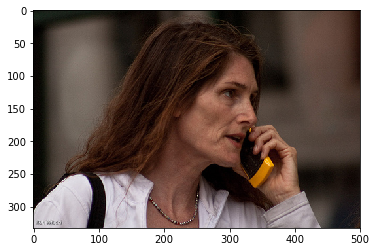

Sample number :  100  / Generated sentence :  a man with a beard and a white shirt is holding a microphone .


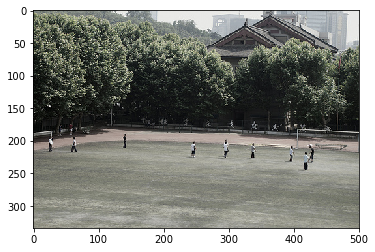

Sample number :  200  / Generated sentence :  a man is walking down a street .


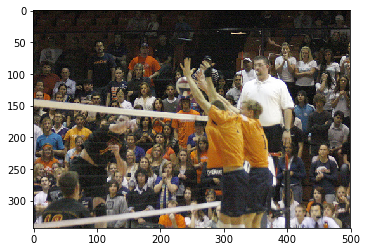

Sample number :  300  / Generated sentence :  a man in a white shirt is jumping in the air with a skateboard .


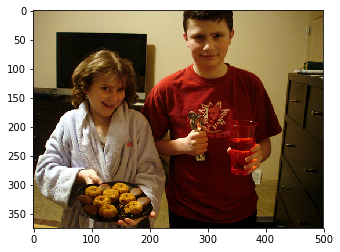

Sample number :  400  / Generated sentence :  a young boy in a blue shirt is holding a .


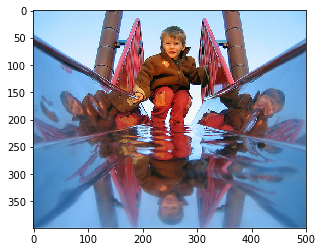

Sample number :  500  / Generated sentence :  a man in a red shirt is holding a flag .


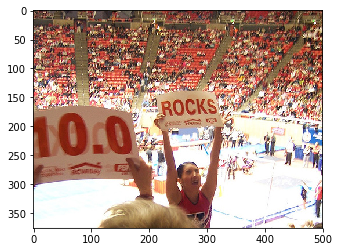

Sample number :  600  / Generated sentence :  a man in a black shirt is holding a flag .


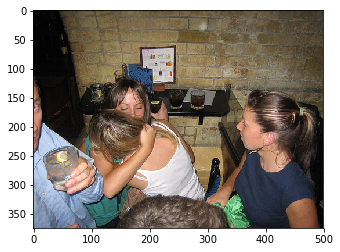

Sample number :  700  / Generated sentence :  a man is playing with a dog .


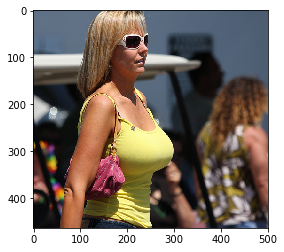

Sample number :  800  / Generated sentence :  a woman in a red tank top is holding a drink .


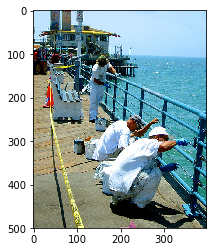

Sample number :  900  / Generated sentence :  a man in a blue shirt is walking on the beach .


IOError: cannot identify image file <open file './data/flickr30k/readme.txt', mode 'rb' at 0x7f0f3c4724b0>

In [5]:
test_and_eval(test_image_path='./data/flickr30k' ,model_path='./models/model-9')